# Modelo numérico para estimativas da dinâmica epidêmica da COVID19

 Referências: <br>
 
 [1] R.M. Cotta, C.P. Naveira-Cotta, and P. Magal, Parametric identification 
    and public health measures influence on the COVID-19 epidemic evolution 
    in Brazil, 2020. 

 Sumário de variáveis utilizadas no modelo SIRU:

 S(t): número de indivíduos passíveis de seren infectados no dia t<br>
 I(t): número de indivíduos infecciosos e assintomáticos no dia t<br>
 R(t): número de indivíduos infecciosos e notificados no dia t<br>
 U(t): número de indivíduos infecciosos e não-notificados no dia t<br>
 CR(t): cumulativo de indivíduos infectados notificados até o dia t<br>
 CU(t): cumulativo de indivíduos infectados não-notificados até o dia t<br>
 f(t): fração de indivíduos assintomáticos se tornarão casos notificados<br>
 1-f(t): fração de indivíduos assintomáticos se tornarão casos não-notificados<br>
 DR(t): número diário de indivíduos notificados<br>

 Premissas:<br>

 1. Indíviduos infecciosos notificados R(t) são removidos (ou isolados) da
 população e não causam novas infecções.<br>
 2. Individuos assintomáticos (I) são infecciosos por um período de Ti dias.<br>
 3. Indivíduos sintomáticos e notificados, ou não,(R ou U) são infecciosos por um período
 de Tr dias;<br>
 4. Todas as infecções acontecem via indivíduos dos grupos I ou U.<br>

Parâmetros do modelo:<br>
 
t    = Intervalo de tempo em dias<br>
Ti   = Tempo médio em que o indivíduo em I permanece infeccioso<br>
Tr   = Tempo médio em que o indivíduo em R permanece infeccioso<br>
f0   = Taxa inicial de notificação de casos<br>
X1   = Parâmetro de ajuste da curva de casos acumulados<br>
X2   = Parâmetro de ajuste da curva de casos acumulados<br>
X3   = Parâmetro de ajuste da curva de casos acumulados<br>
N    = Dias sem medidas de intervenção na dinâmica da epidemia<br>
Nf   = Dias sem medidas de intervenção na contagem de casos<br>
mu   = Parâmetro de ajuste da curva de taxa de transmissão<br>
muf  = Parâmetro de ajuste da curva de taxa de notificação<br>
fmax = Parâmetro de ajuste da curva de taxa de notificação<br>


In [58]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

### Importa os dados

In [59]:
data = scipy.io.loadmat('cumCasesPB.mat')['cumCasesPB']

Text(0.5, 1.0, 'COVID-PB')

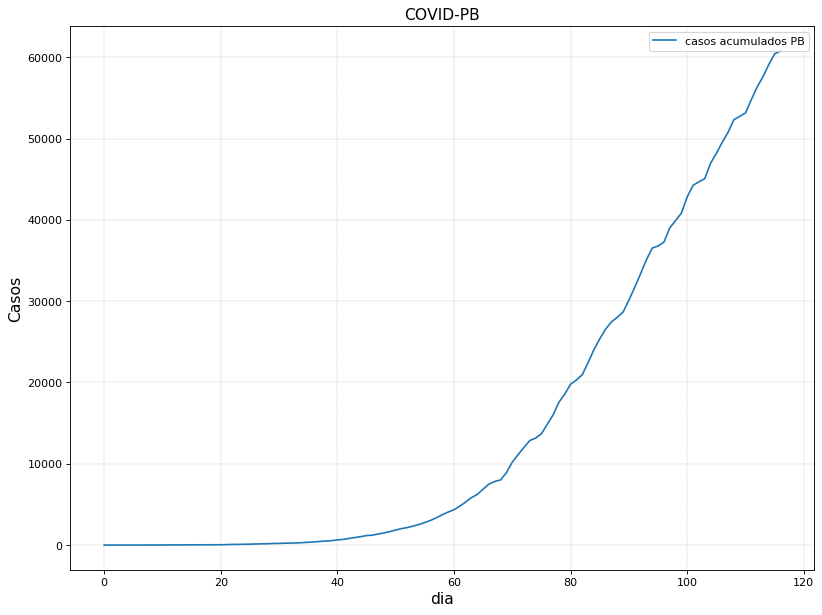

In [60]:
plt.figure(1, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data)
plt.legend(['casos acumulados PB']);
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

### Define funções

In [61]:
def calcMSE(X, CRdata, t):
        CRtest = X[0]*np.exp(X[1]*t)-X[2] 
        mse    = np.mean((CRdata-CRtest)**2, dtype=np.float64)
        return mse
      
        
def funSIRUmodel(param, CRdata, t, X, S0):

        # Parâmetros do modelo:      
        Ti   = param[0]  # Tempo médio em que o indivíduo em I permanece infeccioso
        Tr   = param[0]  # Tempo médio em que o indivíduo em R permanece infeccioso
        f0   = param[1]  # Taxa inicial de notificação de casos
        X1   = X[0]      # Parâmetro de ajuste da curva de casos acumulados
        X2   = X[1]      # Parâmetro de ajuste da curva de casos acumulados
        X3   = X[2]      # Parâmetro de ajuste da curva de casos acumulados
        N    = param[2]  # Dias sem medidas de intervenção na dinâmica da epidemia
        Nf   = len(t)+1  # Dias sem medidas de intervenção na contagem de casos
        mu   = param[3]  # Parâmetro de ajuste da curva de taxa de transmissão
        muf  = 0         # Parâmetro de ajuste da curva de taxa de notificação
        fmax = 0         # Parâmetro de ajuste da curva de taxa de notificação

        # Parâmetros derivados utilizados no modelo:
        vectorT = np.ones(len(t))
        vectorT = vectorT.reshape(len(t),1)
        nu  = 1/Ti;
        eta = 1/Tr;
        f   = f0*vectorT
        nu1 = nu*f*vectorT
        nu2 = nu*(1-f)*vectorT

        S = S0*vectorT                # Número inicial de indivíduos passíveis de infecção
        I = X2*X3/(nu*f[0])*vectorT   # Número inicial de indivíduos infectados assintomáticos
        U = (1-f[0])*(nu/(eta+X2))*I; # Número inicial de indivíduos infectados, sintomáticos e não notificados
        R = 0*vectorT;                # Número inicial de indivíduos infectados, sintomáticos e notificados
        tau0 = (X2+nu)/S[0]*((eta+X2)/((1-f[0])*nu+eta+X2)); # Taxa de infecção inicial
        tau  = tau0*vectorT

        CR = 0*vectorT;    # Número cumulativo de casos notificados
        CU = 0*vectorT;    # Número cumulativo de casos não-notificados
        DR = 0*vectorT;    # Número de notificações diárias

        # SIRU model
        for indT in range(0, len(t)-1):
            if indT > N:
                # A partir do dia N, a taxa de transmissão tau é afetada por medidas de
                # contenção da epidemia:
                tau[indT] = tau0*np.exp(-mu*(indT-N), dtype=np.float64)                
            if indT > Nf:
                # A partir do dia Nf, a taxa de notificação f é afetada por mudanças na
                # metodologia ou quantidade de testes:
                f[indT]=(fmax-f0)*(1-np.exp(-muf*(indT-Nf)))+f[1]
                
            # Integração numérica:
            dS  = -tau[indT]*S[indT]*(I[indT]+U[indT])
            dI  = -dS - nu*I[indT]
            dR  = nu1[indT]*I[indT]-eta*R[indT]
            dU  = nu2[indT]*I[indT]-eta*U[indT]
            dDR = nu1[indT]*f[indT]*I[indT]
            
            S[indT+1]  = S[indT] + dS
            I[indT+1]  = I[indT] + dI
            R[indT+1]  = R[indT] + dR
            U[indT+1]  = U[indT] + dU
            CR[indT+1] = CR[indT] + nu1[indT]*I[indT]
            CU[indT+1] = CU[indT] + nu2[indT]*I[indT]
            DR[indT+1] = CR[indT+1] - CR[indT] 
            
        return CR, CU, S, I, R, U, DR
    
def funSIRUmodelMSE(param, CRdata, t, X, S0):    
        CR, CU, S, I, R, U, DR = funSIRUmodel(param, CRdata, t, X, S0)
        
        # Calcula MSE entre o curva do modelo e os dados de referência:
        mse  = np.mean((CRdata-CR)**2, dtype=np.float64)
        
        return mse

### Ajuste de curva da fase inicial da epidemia (obtenção dos parâmetros X1, X2 e X3)

In [62]:

import scipy.optimize as op

initial_theta = np.array([0.01, 0.01, 1])

CRdata = data[1:30]

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(CRdata),1)

res = op.minimize(calcMSE, initial_theta, args = (CRdata, t), method='Nelder-Mead',tol=1e-8) 

X = res.x
print(X)

[3.42724946 0.14040403 3.74244687]


### Determinação dos demais parâmetros desconhecidos do modelo

In [63]:
initial_theta = np.array([7.0, 0.15, 28, 0.20], dtype=np.float64)

CRdata = data[1:117]
S0 = 3.499e6

t = np.linspace(1,len(CRdata),len(CRdata))
t = t.reshape(len(CRdata),1)

res = op.minimize(funSIRUmodelMSE, initial_theta, args = (CRdata, t, X, S0), method='Nelder-Mead',tol=1e-8) 

param = res.x
print(param)

[5.72801893e+00 3.21626344e-01 2.89903638e+01 1.12965516e-02]


### Plota os gráficos dos dados e do modelo SIRU com parâmetros ajustados

Text(0.5, 1.0, 'COVID-PB')

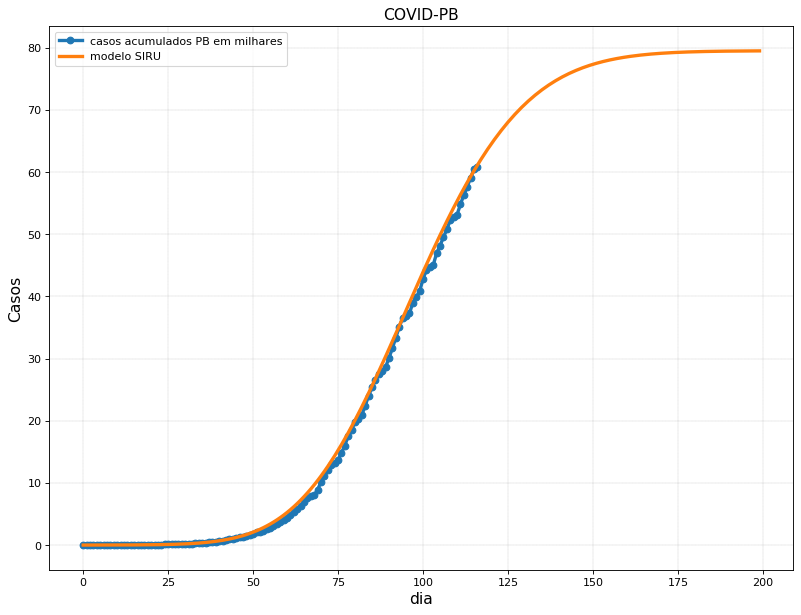

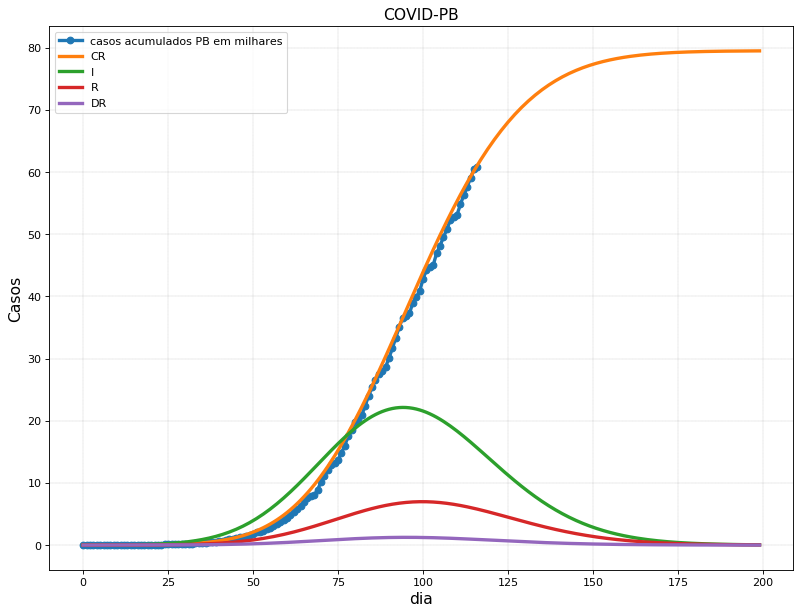

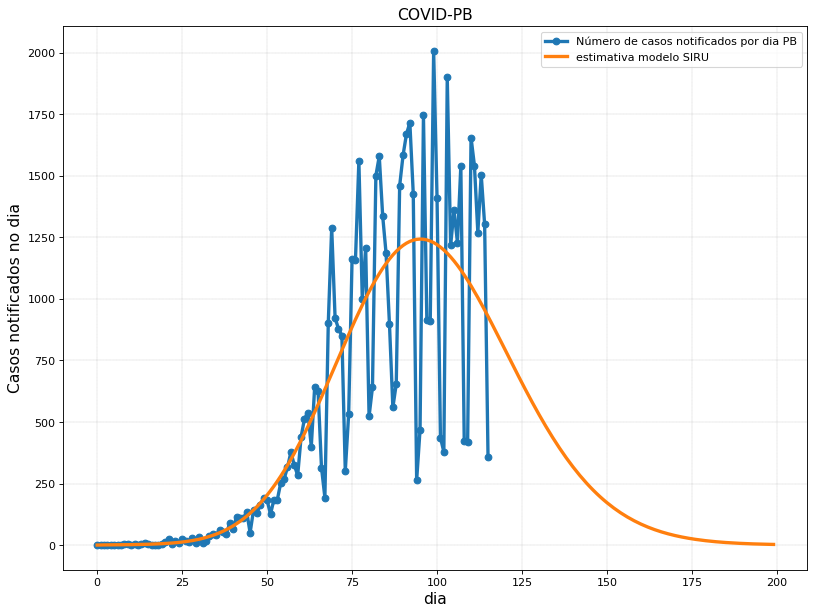

In [64]:

CRdata = data
DRdata = np.diff(data.transpose());
DRdata = DRdata.transpose();

tfinal = 200
#4S0 = 3.499e6

#param = np.array([7.0240, 0.1257, 28.0501, 0.0119], dtype=np.float64)
#X     = np.array([2.9445, 0.1408, 3.5587], dtype=np.float64)

t = np.linspace(1,tfinal,tfinal)
t = t.reshape(tfinal,1)

CR, CU, S, I, R, U, DR = funSIRUmodel(param, CRdata, t, X, S0)

plt.figure(2, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data/1000,marker='o',linewidth=3)
plt.plot(CR/1000,linewidth=3)
plt.legend(['casos acumulados PB em milhares','modelo SIRU']);
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos em milhares', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

plt.figure(3, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data/1000,marker='o',linewidth=3)
plt.plot(CR/1000,linewidth=3)
#plt.plot(CU/1000,linewidth=3)
plt.plot(I/1000,linewidth=3)
plt.plot(R/1000,linewidth=3)
#plt.plot(U/1000,linewidth=3)
plt.plot(DR/1000,linewidth=3)
plt.legend(['casos acumulados PB em milhares', 'CR', 'I', 'R', 'DR']);
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos em milhares', fontsize = 14)
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)

plt.figure(4, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
plt.plot(DRdata, marker='o',linewidth=3)
plt.plot(DR, linewidth=3)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Casos notificados no dia', fontsize = 14)
plt.legend(['Número de casos notificados por dia PB', 'estimativa modelo SIRU']);
plt.xlabel('dia', fontsize = 14)
plt.title('COVID-PB', fontsize = 14)